In [155]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import random
import pickle

# Reading Data

In [183]:
fe = []
with open("train.txt", "r") as f:
    for raw_line in f:
        line = raw_line.strip().split("\t")
        fe.append(len(line))

In [364]:
def create_df(filename="train.txt"):
    data = {'Source':[], 'Sink':[]}
    with open(filename, "r") as f:
        for raw_line in f:
            line = raw_line.strip().split("\t")
            data['Source'] += [line[0]]*(len(line)-1)
            data['Sink'] += line[1:]
    pd_data = pd.DataFrame(data=data)
    pd_data[['Source', 'Sink']] = pd_data[['Source', 'Sink']].apply(pd.to_numeric)
    pd_data = pd_data.drop_duplicates(keep=False)
    return pd_data

In [51]:
def read_sub():
    with open('test-public.txt', 'r') as f:
        # skip the header
        f.readline()
        data = {'Source':[], 'Sink':[]}
        for raw_line in f:
            line = raw_line.strip().split("\t")
            data['Source'].append(int(line[1]))
            data['Sink'].append(int(line[2]))
        return pd.DataFrame(data=data)

In [365]:
data = create_df()

In [366]:
data.head()

,Source,Sink
0,540762,1912140
1,540762,1537559
2,540762,3091331
3,540762,2757277
4,540762,3237295


In [380]:
set(matrix[526124]) == set(data[data['Source'] == 526124]['Sink'])

True

In [382]:
2291110 in set(matrix[526124])

True

In [15]:
out_nodes = set(data['Source'])

In [14]:
data.shape

(23888876, 2)

In [50]:
len(out_nodes)

19570

In [17]:
data.to_csv("processed_train.csv", header=False, index=False)

In [52]:
sub_data = read_sub()

In [55]:
sub_data.head()

,Source,Sink
0,3563811,3600160
1,2052043,1401960
2,4517994,1690636
3,1660006,4349447
4,581111,1882617


In [54]:
sub_data.shape

(2000, 2)

In [29]:
sub_nodes = set(sub_data['Source'].value_counts().keys()).union(sub_data['Sink'].value_counts().keys())

In [32]:
reduced_df = data[(data['Source'].isin(sub_nodes)) | (data['Sink'].isin(sub_nodes))]

In [33]:
reduced_df.shape

(5037682, 2)

In [35]:
data = reduced_df

In [36]:
data.to_csv("processed_train_reduced.csv", header=False, index=False)

In [945]:
y_desire_train

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
lr.test(X_desire)

In [110]:
with open("train.txt","r") as f:
    lines = f.readlines() 

matrix = {}
for line in tqdm(lines):
    temp = list(map(int, line.split()))
    if len(temp[1:]) > 0:
        matrix[temp[0]] = set(temp[1:])

100%|██████████| 20000/20000 [00:10<00:00, 1931.40it/s]


In [111]:
with open("test-public.txt","r") as f:
    test = f.readlines()

test_s = set()
test_d = set()
for l in test[1:]:
    temp = list(map(int, l.split()))
    test_s.add(temp[1]) ; test_d.add(temp[2])

In [112]:
print(len(test_s), len(test_d), len(matrix))

2000 1978 19570


In [113]:
all_v = {}
for v in tqdm(matrix):
    #all_v[v] = all_v.get(v, 0) + 1
    for d in matrix[v]:
        all_v[d] = all_v.get(d, 0) + 1
print(len(all_v))

100%|██████████| 19570/19570 [00:13<00:00, 1415.65it/s]

4867136


1978


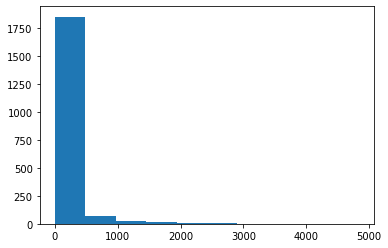

In [114]:
# indegree for sinks in test file
freq = []
for d in test_d:
    freq.append(all_v[d])
freq.sort()
print(len(freq))
plt.hist(freq)
plt.show()

In [115]:
all_freq = list(all_v.values())

In [121]:
print(len([n for n in all_freq if n >= 1 and n <= 5])/len(all_freq))

0.8763747304369551


In [130]:
print(len([n for n in freq if n <= 2])/len(freq))

0.14711830131445905


In [132]:
"""
sink distribution estimation

start         end    pmf    cdf
        x  <= 2   -- 0.15   0.15  
2    <  x  <= 6   -- 0.1    0.25  
6    <  x  <= 13  -- 0.1    0.35  
13   <  x  <= 25  -- 0.1    0.45  
25   <  x  <= 45  -- 0.1    0.55
45   <  x  <= 70  -- 0.1    0.65
70   <  x  <= 120 -- 0.1    0.75
120  <  x  <= 240 -- 0.1    0.85
240  <  x         -- 0.15   1  
"""
pmf = np.array([0.15] + [0.1] * 7 + [0.15])

In [133]:
to_node = {n:[] for n in range(9)}
to_dis = {}

for v in tqdm(all_v):
    indegree = all_v[v]
    if indegree <= 2:
        to_node[0].append(v)
        to_dis[v] = 0
    elif indegree <= 6:
        to_node[1].append(v)
        to_dis[v] = 1
    elif indegree <= 13:
        to_node[2].append(v)
        to_dis[v] = 2
    elif indegree <= 25:
        to_node[3].append(v)
        to_dis[v] = 3
    elif indegree <= 45:
        to_node[4].append(v)
        to_dis[v] = 4
    elif indegree <= 70:
        to_node[5].append(v)
        to_dis[v] = 5
    elif indegree <= 120:
        to_node[6].append(v)
        to_dis[v] = 6
    elif indegree <= 240:
        to_node[7].append(v)
        to_dis[v] = 7
    else:
        to_node[8].append(v)
        to_dis[v] = 8

100%|██████████| 4867136/4867136 [00:04<00:00, 1014316.12it/s]


In [149]:
# sample some edges based on the above distribution
SAMPLES = 20000

data = []

all_source = list(matrix.keys())
max_dis_sample = SAMPLES*pmf

cumulative_sample = np.zeros(9)


while len(data) < SAMPLES//2:
    target_source = random.choice(all_source)
    target_sink = random.sample(matrix[target_source], 1)[0]
    sink_dis = to_dis[target_sink]
    if cumulative_sample[sink_dis] < max_dis_sample[sink_dis] and target_source != target_sink:
        cumulative_sample[sink_dis] += 1
        data.append([len(data), target_source, target_sink, 1])

In [375]:
len(set(matrix[2712039]))

63

In [150]:
print(max_dis_sample)
print(cumulative_sample)

[3000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 3000.]
[1399. 1077.  966. 1028. 1025.  756.  951.  969. 1829.]


In [151]:
pmf

array([0.15, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.15])

In [152]:
# sample some neg edge from the graph

for i in range(len(pmf)):
    while cumulative_sample[i] < max_dis_sample[i]:
        src = random.choice(all_source)
        dest = random.choice(to_node[i])
        if dest != src and dest not in matrix[src]:
            data.append([len(data), src, dest, 0])
            cumulative_sample[i] += 1

random.shuffle(data)

In [153]:
print(max_dis_sample)
print(cumulative_sample)

[3000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 3000.]
[3000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 3000.]


In [156]:
with open('data/train-mix.p', 'wb') as f:
    pickle.dump(data, f)

In [158]:
with open('data/matrix.p', 'wb') as f:
    pickle.dump(matrix, f)

In [360]:
len(set(sub_data['Source']).union(sub_data['Sink']))

3948

In [363]:
data

[[3966, 2712039, 218222, 1],
 [13826, 3296670, 3092525, 0],
 [18559, 1569537, 281790, 0],
 [14849, 3750582, 528038, 0],
 [3676, 3253990, 3008062, 1],
 [14879, 4126485, 2978899, 0],
 [6342, 2353654, 1863046, 1],
 [17047, 1227313, 109141, 0],
 [1595, 685695, 2410046, 1],
 [12578, 3262992, 2677316, 0],
 [3546, 2323088, 2309976, 1],
 [8157, 2466503, 4800253, 1],
 [5010, 878044, 2541835, 1],
 [7265, 4672710, 3783690, 1],
 [12900, 2806975, 1202129, 0],
 [12087, 3079468, 3325422, 0],
 [12682, 10090, 545853, 0],
 [11214, 4550069, 3248447, 0],
 [18558, 4786270, 3205531, 0],
 [2483, 2198488, 1971518, 1],
 [8905, 3063001, 1659272, 1],
 [5280, 3869033, 2572933, 1],
 [19560, 1896126, 2402775, 0],
 [14346, 3063973, 1380739, 0],
 [9280, 3228493, 1304921, 1],
 [18631, 3545321, 3708550, 0],
 [17997, 1550614, 2349803, 0],
 [3004, 2052207, 2055238, 1],
 [18820, 2360726, 3050762, 0],
 [18545, 4749438, 4346941, 0],
 [8471, 2595454, 1577010, 1],
 [19420, 4696379, 428622, 0],
 [17591, 4559284, 3591170, 0],
 

# Data Analysis

### Visualising using networkx

In [23]:
# g = nx.read_edgelist('processed_train.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
g = nx.from_pandas_edgelist(data, "Source", "Sink", create_using=nx.DiGraph())

In [56]:
g_test = nx.from_pandas_edgelist(sub_data, "Source", "Sink", create_using=nx.DiGraph())

In [162]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 4842581
Number of edges: 23888876
Average in degree:   4.9331
Average out degree:   4.9331


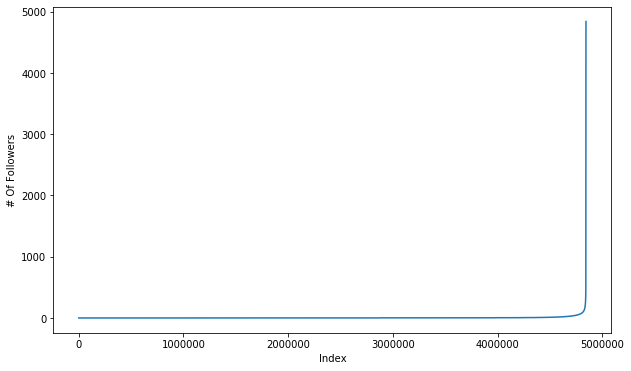

In [361]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index')
plt.ylabel('# Of Followers')
plt.show()

In [86]:
test_sink = set(sub_data['Sink'])
test_source = set(sub_data['Source'])

In [88]:
for i in test_sink:
    print(i)

1900547
2146310
1187846
3227660
3350546
2113556
180252
1867811
3481639
1474599
1646634
1089581
2441262
450606
4046914
1843267
1065029
4202576
3366994
2809938
1499223
2449495
3342431
2039908
2547815
4210797
1761389
24687
770163
909435
2457732
508039
852104
327819
1310861
4407437
2449551
1024144
811154
2293906
1343638
1564823
1900696
4538521
1761432
1122465
4358309
4079785
3473583
434351
4612272
1188020
975030
2875576
1704126
2744512
573643
2441425
3924181
1163482
2875611
2457828
2654447
2801903
4071665
884982
581881
2212090
8446
3842326
3014937
3670301
639262
2089250
1630500
2335027
401716
1147187
1737013
3096888
3113273
2015545
540988
2441535
262463
1352000
975170
4776261
2695493
1999174
4825421
786765
2072911
4702544
4161872
778578
2851163
1155426
3490147
1655138
3064168
3064171
4702587
74116
1106311
65928
1843598
2662809
2367900
1515937
3129768
4260267
3563963
2220479
549313
4039112
1171914
4260311
786905
1638876
2310626
1335782
3326440
3056105
3383792
1434096
3203581
3973631
500235


In [100]:
all_v[485713]

1

In [99]:
for i in test_sink:
    try:
        g.in_degree(i)
    except:
        print(i)
        break

485713


In [201]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist, 90+i))

90 percentile value is 5.0
91 percentile value is 5.0
92 percentile value is 5.0
93 percentile value is 6.0
94 percentile value is 6.0
95 percentile value is 7.0
96 percentile value is 8.0
97 percentile value is 9.0
98 percentile value is 11.0
99 percentile value is 17.0
100 percentile value is 513.0


In [202]:
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 17.0
99.2 percentile value is 19.0
99.3 percentile value is 20.0
99.4 percentile value is 22.0
99.5 percentile value is 24.0
99.6 percentile value is 27.4320000000007
99.7 percentile value is 32.0
99.8 percentile value is 41.0
99.9 percentile value is 70.0
100.0 percentile value is 513.0


In [203]:
print('# of persons who have no followers' ,sum(np.array(indegree_dist)==0),'and % is',
        sum(np.array(indegree_dist)==0)*100/len(indegree_dist))

# of persons who have no followers 2126 and % is 1.5731484427606313


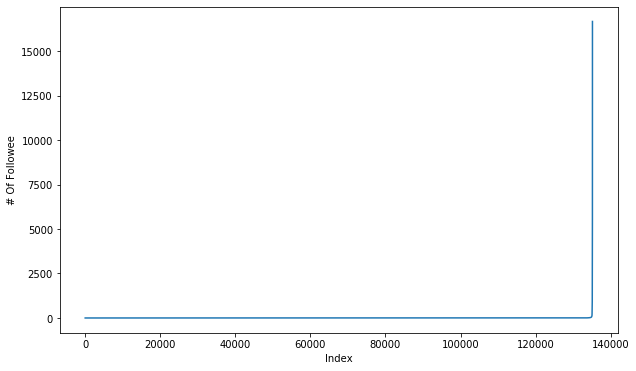

In [204]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index')
plt.ylabel('# Of Followee')
plt.show()

In [205]:
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist, 99+(i/100)))

99.1 percentile value is 9.0
99.2 percentile value is 10.0
99.3 percentile value is 12.0
99.4 percentile value is 16.0
99.5 percentile value is 19.29000000000815
99.6 percentile value is 25.0
99.7 percentile value is 35.0
99.8 percentile value is 53.0
99.9 percentile value is 130.57400000002235
100.0 percentile value is 16663.0


In [206]:
for i in range(900,1010,10):
    print(99+(i/1000),'percentile value is',np.percentile(outdegree_dist, 99+(i/1000)))

99.9 percentile value is 130.57400000002235
99.91 percentile value is 150.11660000003758
99.92 percentile value is 192.772799999977
99.93 percentile value is 283.0
99.94 percentile value is 367.7847999999649
99.95 percentile value is 450.1450000000186
99.96 percentile value is 992.9103999985382
99.97 percentile value is 1957.8700000006938
99.98 percentile value is 2699.630799999868
99.99 percentile value is 5250.934399997117
100.0 percentile value is 16663.0


In [207]:
print('# of persons those are not following anyone are', sum(np.array(outdegree_dist)==0),'and % is',
        sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist))

# of persons those are not following anyone are 132537 and % is 98.07167222867629


# Negative Data preparing and Train-validation split

In [208]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 135143
Number of edges: 323932
Average in degree:   2.3970
Average out degree:   2.3970


### generate random missing edge

In [209]:
import random
import csv
# getting the processed connection
raw_connection = csv.reader(open('processed_train.csv', 'r'))

exist_edges = {}

for edge in raw_connection:
    exist_edges[(edge[0], edge[1])] = 1

# in order to prevent overfitting, we generate the same number of negative edge
missing_edges = set()
while(len(missing_edges) < 323932):
    a = random.randint(1, 135143)
    b = random.randint(1, 135143)
    if a == b:
        continue
        
    existance = exist_edges.get((a,b), -1)
    if existance == -1:
        try:
            # if distance within 2, that means they share a common follower and very likely to be friends in real world or at least know each others
            if nx.shortest_path_length(g, source=a, target=b) > 2:
                missing_edges.add((a,b))
            else:
                continue
        except:
            missing_edges.add((a,b))

In [210]:
len(missing_edges)

323932

In [211]:
import pickle
pickle.dump(missing_edges, open('data/missing_edges_final.p', 'wb'))

### Train-Test Partition

In [212]:
negative_data = pd.DataFrame(list(missing_edges), columns=['Source', 'Sink'])

In [765]:
len(data)

323932

In [766]:
len(negative_data)

323932

In [215]:
from sklearn.model_selection import train_test_split
#Trian test split 
#positive links and negative links seperatly because we need positive training data only for creating graph and for feature generation
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(data, np.ones(len(data)), test_size=0.2, random_state=90051)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(negative_data, np.zeros(len(negative_data)), test_size=0.2, random_state=90051)

In [216]:
# !TODO the data is not perfectly balanced, maybe fixed this later
print('='*60)
print("Number of nodes in the train data graph with edges", y_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", y_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", y_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", y_test_neg.shape[0])

Number of nodes in the train data graph with edges 259145
Number of nodes in the train data graph without edges 259145
Number of nodes in the test data graph with edges 64787
Number of nodes in the test data graph without edges 64787


In [217]:
#removing header and saving
X_train_pos.to_csv('data/train_pos.csv',header=False, index=False)
X_test_pos.to_csv('data/test_pos.csv',header=False, index=False)
X_train_neg.to_csv('data/train_neg.csv',header=False, index=False)
X_test_neg.to_csv('data/test_neg.csv',header=False, index=False)

In [218]:
# X_train = X_train_pos.append(X_train_neg, ignore_index=True)
# y_train = np.concatenate((y_train_pos, y_train_neg))
# X_test = X_test_pos.append(X_test_neg, ignore_index=True)
# y_test = np.concatenate((y_test_pos, y_test_neg))

# Feature Engineering

In [219]:
#generate train and test graph
train_graph = nx.read_edgelist('data/train_pos.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 117429
Number of edges: 259145
Average in degree:   2.2068
Average out degree:   2.2068


In [267]:
def jaccard_followees(a, b, train_graph=g):
    try:
        if len(set(train_graph.successors(a))) == 0 or len(set(train_graph.successors(b))) == 0:
            return 0
        else:
            intersection = len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
            union = len(set(train_graph.successors(a)).union(set(train_graph.successors(b))))
            return intersection/union
    except:
        return 0
    return sim

def jaccard_followers(a,b, train_graph=g):
    try:
        if set(train_graph.predecessors(a)) == 0 or len(set(g.predecessors(b))) == 0:
            return 0
        else:
            intersection = len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b))))
            union = len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b))))
            return intersection/union
    except:
        return 0

In [320]:
import math
#for followees
def cosine_followees(a, b, train_graph=g):
    try:
        if len(set(train_graph.successors(a))) == 0 or len(set(train_graph.successors(b))) == 0:
            print("yes")
            return 0
        else:
            return (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
    except:
        return 0
    
def cosine_followers(a, b, train_graph=g):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0 or len(set(train_graph.predecessors(b))) == 0:
            return 0
        else:
            print(len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))
            return (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
    except:
        return 0

In [322]:
X_desire_train.iloc[3]

Source    4707515
Sink      4277788
Name: 3, dtype: int64

In [334]:
asdf = 14
cosine_followees(X_desire_train.iloc[asdf]['Source'], X_desire_train.iloc[asdf]['Sink'])

yes


0

In [335]:
import math
def cosine_sim(a:set(), b:set()) -> float:
    if (len(a) == 0 or len(b) == 0):
        return 0
    else:
        return len(a.intersection(b))/(math.sqrt(len(a)*len(b)))

In [345]:
def user_based_rec(a, b, graph=g):
    try:
        source_succ = set(g.successors(a))
        other_users = set(g.predecessors(b))
    except:
        return 0
    
    # calculating the max similarity of all
    max_sim = 0
    for u in other_users:
        temp = set(g.successors(u))
        temp.remove(b)
        curr_sim = cosine_sim(temp, source_succ)
        if curr_sim > max_sim:
            max_sim = curr_sim
    return max_sim

In [ ]:
# def item_based_rec(a, b, graph=g):
#     try:
#         source_succ = set(g.successors(a))
#     except:
#         return 0
    
#     max_sim = 0
#     for u in source_succ:
        
    

In [311]:
# caclulating the page rank for each node pair
pr = nx.pagerank(train_graph, alpha=0.85)
pickle.dump(pr,open('data/page_rank.p','wb'))
# use the mean for all the data points which are part of the test dataset but are not in the training dataset
mean_pr = float(sum(pr.values())) / len(pr)

print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean', mean_pr)

min 8.362051873775734e-06
max 0.00048134944932700383
mean 8.515784005649403e-06


In [168]:
def compute_shortest_path_length(a, b, train_graph=g):
    p = 99
    try:
        # if the edge already exist, we first remove the edge which let our model better understand the graph
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return 99

In [225]:
# #getting weakly connected edges from graph 
# def belongs_to_same_wcc(a, b, train_graph=train_graph):
#     wcc = list(nx.weakly_connected_components(train_graph))
#     index = []
#     # they must belongs are there is a path
#     if train_graph.has_edge(b,a):
#         return 1
    
#     if train_graph.has_edge(a,b):
#         for i in wcc:
#             if a in i:
#                 index = i
#                 break
#         if b in index:
#             train_graph.remove_edge(a,b)
#             if compute_shortest_path_length(a,b) == -1:
#                 train_graph.add_edge(a,b)
#                 return 0
#             else:
#                 train_graph.add_edge(a,b)
#                 return 1
#         else:
#             return 0
#     else:
#         for i in wcc:
#             if a in i:
#                 index = i
#                 break
#         if(b in index):
#             return 1
#         else:
#             return 0

In [169]:
# Adar Index
def calc_adar_in(a, b, train_graph=g):
    sum = 0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [314]:
#Katz centrality of a node is a measure of centrality in a network
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
pickle.dump(katz, open('data/katz.p','wb'))
mean_katz = float(sum(katz.values())) / len(katz)

print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean', mean_katz)

min 0.0028783732537377513
max 0.008538168742251223
mean 0.0029169324653439484


In [315]:
#HITS
hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
pickle.dump(hits, open('data/hits.p','wb'))
mean_hits = float(sum(hits[0].values())) / len(hits[0])

print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean', mean_hits)

min 0.0
max 0.07111477112379715
mean 8.515784005654462e-06


In [171]:
def common_neighbours(a, b, graph=g):
    try:
        a_set = set(graph.successors(a)).union(graph.predecessors(a))
        b_set = set(graph.successors(b)).union(graph.predecessors(b))
    except:
        return 0
    
    return len(a_set.intersection(b_set))

In [172]:
def preferencial_attchment(a, b, graph=g):
    try:
        a_set = set(graph.successors(a)).union(graph.predecessors(a))
        b_set = set(graph.successors(b)).union(graph.predecessors(b))
    except:
        return 0
    
    return len(a_set)*len(b_set)

### Extracting features

In [228]:
# try to reduce the sample size, TODO, might fix this later
desire_train = 100000
desire_test = 50000
d_train_pos = sorted(random.sample(range(len(X_train_pos)), int(desire_train/2)))
d_test_pos = sorted(random.sample(range(len(X_test_pos)), int(desire_test/2)))
d_train_neg = sorted(random.sample(range(len(X_train_neg)), int(desire_train/2)))
d_test_neg = sorted(random.sample(range(len(X_test_neg)), int(desire_test/2)))

In [229]:
def shrink_df(df, label, num_list):
    if num_list == -1:
        return df, label
    desire_dict = {"Source":[], "Sink":[]}
    lb = []
    for i in num_list:
        desire_dict['Source'].append(df.iloc[i]['Source'])
        desire_dict['Sink'].append(df.iloc[i]['Sink'])
        lb.append(label[i])
    return pd.DataFrame(data=desire_dict), np.array(lb)

In [230]:
X_desire_train_pos, y_desire_train_pos = shrink_df(X_train_pos, y_train_pos, d_train_pos)
X_desire_train_neg, y_desire_train_neg = shrink_df(X_train_neg, y_train_neg, d_train_neg)

In [231]:
X_desire_test_pos, y_desire_test_pos = shrink_df(X_test_pos, y_test_pos, d_test_pos)
X_desire_test_neg, y_desire_test_neg = shrink_df(X_test_neg, y_test_neg, d_test_neg)

In [232]:
X_desire_train = X_desire_train_pos.append(X_desire_train_neg, ignore_index=True)
X_desire_test = X_desire_test_pos.append(X_desire_test_neg, ignore_index=True)

y_desire_train = np.append(y_desire_train_pos, y_desire_train_neg)
y_desire_test = np.append(y_desire_test_pos, y_desire_test_neg)

In [321]:
print(len(X_desire_train), len(y_desire_train), len(X_desire_test), len(y_desire_test))

100000 100000 50000 50000


#### Split distribution data

In [175]:
from sklearn.model_selection import train_test_split
link = [[i[1], i[2]] for i in data]
label = [i[3] for i in data]
X_desire_train, X_desire_test, y_desire_train, y_desire_test = train_test_split(link, label, test_size=0.2)

In [176]:
print(len(X_desire_train), len(y_desire_train), len(X_desire_test), len(y_desire_test))

16000 16000 4000 4000


In [181]:
X_desire_train = pd.DataFrame(X_desire_train, columns=['Source', 'Sink'])

In [182]:
X_desire_test = pd.DataFrame(X_desire_test, columns=['Source', 'Sink'])

#### Calculating features

In [342]:
X_train_features = pd.DataFrame()
X_test_features = pd.DataFrame()

In [343]:
#mapping jaccrd followers to train and test data
X_train_features['jaccard_followers'] = X_desire_train.apply(lambda row:jaccard_followers(row['Source'], row['Sink']), axis=1)
X_test_features['jaccard_followers'] = X_desire_test.apply(lambda row:jaccard_followers(row['Source'], row['Sink']),axis=1)

#mapping jaccrd followees to train and test data
X_train_features['jaccard_followees'] = X_desire_train.apply(lambda row:jaccard_followees(row['Source'], row['Sink']), axis=1)
X_test_features['jaccard_followees'] = X_desire_test.apply(lambda row:jaccard_followees(row['Source'], row['Sink']), axis=1)

# # #mapping jaccrd followers to train and test data
# X_train_features['cosine_followers'] = X_desire_train.apply(lambda row:cosine_followers(row['Source'], row['Sink']), axis=1)
# X_test_features['cosine_followers'] = X_desire_test.apply(lambda row:cosine_followers(row['Source'], row['Sink']), axis=1)

# #mapping jaccrd followees to train and test data
# X_train_features['cosine_followees'] = X_desire_train.apply(lambda row:cosine_followees(row['Source'], row['Sink']), axis=1)
# X_test_features['cosine_followees'] = X_desire_test.apply(lambda row:cosine_followees(row['Source'], row['Sink']), axis=1)

In [347]:
X_train_features['user_base_rec'] = X_desire_train.apply(lambda row: user_based_rec(row['Source'], row['Sink']), axis=1)
X_test_features['user_base_rec'] = X_desire_test.apply(lambda row: user_based_rec(row['Source'], row['Sink']), axis=1)

KeyboardInterrupt: 

In [ ]:
def compute_features_stage1(df_final):
    #calculating # of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    
    for i, row in df_final.iterrows():
        try:
            s1 = set(g.predecessors(row['Source']))
            s2 = set(g.successors(row['Sink']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1 = set(g.predecessors(row['Source']))
            d2 = set(g.successors(row['Sink']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

X_train_features['num_followers_s'], X_train_features['num_followers_d'], \
X_train_features['num_followees_s'], X_train_features['num_followees_d'], \
X_train_features['inter_followers'], X_train_features['inter_followees'] = compute_features_stage1(X_desire_train)

X_test_features['num_followers_s'], X_test_features['num_followers_d'], \
X_test_features['num_followees_s'], X_test_features['num_followees_d'], \
X_test_features['inter_followers'], X_test_features['inter_followees'] = compute_features_stage1(X_desire_test)

In [ ]:
# mapping adar index
X_train_features['adar_index'] = X_desire_train.apply(lambda row: calc_adar_in(row['Source'], row['Sink']), axis=1)
X_test_features['adar_index'] = X_desire_test.apply(lambda row: calc_adar_in(row['Source'], row['Sink']), axis=1)

In [ ]:
X_train_features['shortest_path'] = X_desire_train.apply(lambda row: compute_shortest_path_length(row['Source'], row['Sink']), axis=1)
X_test_features['shortest_path'] = X_desire_test.apply(lambda row: compute_shortest_path_length(row['Source'], row['Sink']), axis=1)

In [918]:
X_train_features['page_rank_s'] = X_desire_train['Source'].apply(lambda x:np.sqrt(pr.get(x, mean_pr)))
X_train_features['page_rank_d'] = X_desire_train['Sink'].apply(lambda x:np.sqrt(pr.get(x, mean_pr)))
X_test_features['page_rank_s'] = X_desire_test['Source'].apply(lambda x:np.sqrt(pr.get(x, mean_pr)))
X_test_features['page_rank_d'] = X_desire_test['Sink'].apply(lambda x:np.sqrt(pr.get(x, mean_pr)))

In [686]:
#Katz centrality score for source and destination in Train and test
#if anything not there in train graph then adding mean katz score
X_train_features['katz_s'] = X_desire_train['Source'].apply(lambda x: katz.get(x,mean_katz))
X_train_features['katz_d'] = X_desire_train['Sink'].apply(lambda x: katz.get(x,mean_katz))
X_test_features['katz_s'] = X_desire_test['Source'].apply(lambda x: katz.get(x,mean_katz))
X_test_features['katz_d'] = X_desire_test['Sink'].apply(lambda x: katz.get(x,mean_katz))

In [332]:
#Hits algorithm score for source and destination in Train and test
#if anything not there in train graph then adding 0
X_train_features['hubs_s'] = X_desire_train['Source'].apply(lambda x: hits[0].get(x,0))
X_train_features['hubs_d'] = X_desire_train['Sink'].apply(lambda x: hits[0].get(x,0))
X_test_features['hubs_s'] = X_desire_test['Source'].apply(lambda x: hits[0].get(x,0))
X_test_features['hubs_d'] = X_desire_test['Sink'].apply(lambda x: hits[0].get(x,0))

In [333]:
X_train_features['authorities_s'] = X_desire_train['Source'].apply(lambda x: hits[1].get(x,0))
X_train_features['authorities_d'] = X_desire_train['Sink'].apply(lambda x: hits[1].get(x,0))
X_test_features['authorities_s'] = X_desire_test['Source'].apply(lambda x: hits[1].get(x,0))
X_test_features['authorities_d'] = X_desire_test['Sink'].apply(lambda x: hits[1].get(x,0))

In [ ]:
# calculate common neighbours
X_train_features['c_nei'] = X_desire_train.apply(lambda row: common_neighbours(row['Source'], row['Sink']), axis=1)
X_test_features['c_nei'] = X_desire_test.apply(lambda row: common_neighbours(row['Source'], row['Sink']), axis=1)

In [ ]:
X_train_features['prefer'] = X_desire_train.apply(lambda row: preferencial_attchment(row['Source'], row['Sink']), axis=1)
X_test_features['prefer'] = X_desire_test.apply(lambda row: preferencial_attchment(row['Source'], row['Sink']), axis=1)

In [685]:
pickle.dump(X_train_features, open('data/X_train_features.p','wb'))
pickle.dump(X_test_features, open('data/X_test_features.p','wb'))

In [914]:
X_train_features = pickle.load(open('data/X_train_features.p','rb'))
X_test_features = pickle.load(open('data/X_test_features.p','rb'))

In [683]:
X_train_features.drop(["shortest_path"], axis=1, inplace=True)

In [ ]:
X_train_features.shape

In [ ]:
X_train_features.columns

In [920]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer(norm='l1')

scaler.fit(X_train_features)
X_train_features = scaler.transform(X_train_features)

scaler.fit(X_test_features)
X_test_features = scaler.transform(X_test_features)

In [281]:
X_train_features.describe()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,shortest_path,c_nei,prefer
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.00000,16000.00000,16000.000000,16000.000000,16000.00000,16000.000000,16000.000000,16000.000000,16000.000000,1.600000e+04
mean,0.030465,0.006258,0.012653,0.013610,91.49025,91.49025,1725.423000,1725.423000,91.49025,1725.423000,2.314580,8.810375,10.879563,8.845300e+05
std,0.062404,0.027635,0.029386,0.051245,191.71842,191.71842,25227.490272,25227.490272,191.71842,25227.490272,46.312512,23.812845,88.529500,2.699787e+07
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,12.00000,12.00000,0.000000,0.000000,12.00000,0.000000,0.000000,2.000000,0.000000,9.200000e+02
50%,0.003735,0.000000,0.001058,0.000000,35.00000,35.00000,0.000000,0.000000,35.00000,0.000000,0.000000,2.000000,1.000000,7.200000e+03
75%,0.032967,0.000000,0.012033,0.000000,92.00000,92.00000,0.000000,0.000000,92.00000,0.000000,0.000000,3.000000,7.000000,4.806000e+04
max,0.800000,0.500000,0.707107,0.683763,4841.00000,4841.00000,759391.000000,759391.000000,4841.00000,759391.000000,5368.793317,99.000000,9644.000000,2.840350e+09


In [921]:
X_train_features

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.74800551e-05, 8.23831024e-06],
       [1.54408709e-02, 1.73492932e-04, 0.00000000e+00, ...,
        0.00000000e+00, 1.89413210e-05, 1.11723070e-05],
       [5.22159867e-03, 4.07937396e-05, 0.00000000e+00, ...,
        0.00000000e+00, 1.55087695e-05, 7.55194136e-06],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 5.02238595e-01, 4.97761405e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 5.02263071e-01, 4.97736929e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 5.00000000e-01, 5.00000000e-01]])

# Build the model

In [279]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=90051)
lr_clf.fit(X_train_features, y_desire_train)

/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=90051, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [357]:
sub_data[sub_data['Source'] == 2184483]

,Source,Sink


In [280]:
lr_clf.score(X_test_features, y_desire_test)

0.53775

In [284]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=3, random_state=90051, n_jobs=-1)
rf_clf.fit(X_train_features, y_desire_train)

/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=90051, verbose=0,
                       warm_start=False)

In [237]:
from sklearn.model_selection import GridSearchCV

base = RandomForestClassifier(n_estimators=100)
parameters = {
    "max_depth":[5,7,9,11,13],
    "min_samples_leaf":[1,3,5],
    "min_samples_split":[2,4,6,8,10],
    "max_features":["sqrt", "log2"]
}

rf_grid = GridSearchCV(base, parameters, n_jobs=-1)
rf_grid.fit(X_train_features, y_desire_train)
print(rf_grid.score(X_test_features, y_desire_test))

/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


NameError: name 'X_test' is not defined

In [285]:
rf_clf.score(X_test_features, y_desire_test)

0.79

In [286]:
rf_clf.predict_proba(X_test_features)

array([[0.60063231, 0.39936769],
       [0.37558417, 0.62441583],
       [0.53451119, 0.46548881],
       ...,
       [0.31787412, 0.68212588],
       [0.51343121, 0.48656879],
       [0.73528877, 0.26471123]])

In [204]:
from sklearn.metrics import roc_auc_score
def evaluate_roc_auc(clf, features, labels):
    predicted = clf.predict_proba(features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(labels, predicted[:, positive_column])

In [287]:
evaluate_roc_auc(rf_clf, X_test_features, y_desire_test)

0.8421342128712425

In [894]:
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
#Building Model using best parameter
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 
                'n_estimators': [100, 200, 300, 400, 500], 
                'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
# clf = GridSearchCV(
#     xgb.XGBClassifier(base_score=0.5, 
#                   booster='gbtree', 
#                   colsample_bylevel=1, 
#                   colsample_bytree=1, 
#                   gamma=0, 
#                   learning_rate=0.05, 
#                   max_delta_step=0,
#                   max_depth=4, 
#                   min_child_weight=1, 
#                   missing=None, 
#                   n_estimators=500,
#                   n_jobs=1, 
#                   nthread=None,
#                   objective='binary:logistic', 
#                   random_state=0,
#                   reg_alpha=0, 
#                   reg_lambda=1.0, 
#                   scale_pos_weight=1, 
#                   seed=None,
#                   silent=False, 
#                   subsample=1), 
#     tuned_params, 
#     scoring = 'roc_auc', 
#     n_jobs=-1
# )

xgb_clf = xgb.XGBClassifier(base_score=0.5, 
                  booster='gbtree',
                  colsample_bylevel=1, 
                  colsample_bytree=1,
                  gamma=0,
                  learning_rate=0.05,
                  max_delta_step=0,
                  max_depth=2,
                  min_child_weight=1,
                  missing=None,
                  n_estimators=500,
                  n_jobs=5,
                  nthread=None,
                  objective='binary:logistic',
                  random_state=0,
                  reg_alpha=0,
                  reg_lambda=1.0,
                  scale_pos_weight=1,
                  seed=None,
                  subsample=1)

xgb_clf.fit(X_train_features, y_desire_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=500, n_jobs=5, nthread=5, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1.0, scale_pos_weight=1, seed=0, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [895]:
xgb_clf.score(X_test_features, y_desire_test)

0.9513

In [455]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('lr', lr_clf), ('xgb', clf), ('rf', rf_clf)], voting='soft')

In [532]:
voting.fit(X_train_features, y_desire_train)

/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=90051,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsa...
                                                     clas

In [533]:
voting.score(X_test_features, y_desire_test)

0.80916

In [560]:
from sklearn.neural_network import MLPClassifier

In [749]:
mlp_clf = MLPClassifier(
    max_iter=200,
    early_stopping=True,
    shuffle=True,
    solver='adam',
    activation='relu',
).fit(X_train_features, y_desire_train)

In [751]:
evaluate_roc_auc(mlp_clf, X_test_features, y_desire_test)

0.8428827031999999

In [575]:
visual_train = X_train_features.copy()
visual_train['label'] = y_desire_train

In [579]:
visual_train[(visual_train['shortest_path'] != 99) & (visual_train['label'] == 1)].describe()

,shortest_path,c_nei,label
count,30249.000000,30249.000000,30249.0
mean,2.306886,4.481470,1.0
std,0.536001,47.755137,0.0
min,2.000000,0.000000,1.0
25%,2.000000,1.000000,1.0
50%,2.000000,2.000000,1.0
75%,3.000000,4.000000,1.0
max,8.000000,4334.000000,1.0


In [581]:
visual_train[(visual_train['shortest_path'] == 99) & (visual_train['label'] == 0)].describe()

,shortest_path,c_nei,label
count,50000.0,50000.000000,50000.0
mean,99.0,0.000040,0.0
std,0.0,0.006324,0.0
min,99.0,0.000000,0.0
25%,99.0,0.000000,0.0
50%,99.0,0.000000,0.0
75%,99.0,0.000000,0.0
max,99.0,1.000000,0.0


# Genereate Submission

In [208]:
sub_data.head()

,Source,Sink
0,3563811,3600160
1,2052043,1401960
2,4517994,1690636
3,1660006,4349447
4,581111,1882617


In [288]:
X_sub = pd.DataFrame()

In [263]:
origial_graph = nx.read_edgelist('processed_train.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(origial_graph))

Name: 
Type: DiGraph
Number of nodes: 4842581
Number of edges: 23888876
Average in degree:   4.9331
Average out degree:   4.9331


In [811]:
# caclulating the page rank for each node pair
pr_original = nx.pagerank(origial_graph, alpha=0.85)
pickle.dump(pr,open('data/page_rank_original.p','wb'))
# use the mean for all the data points which are part of the test dataset but are not in the training dataset
mean_pr_original = float(sum(pr.values())) / len(pr)

In [211]:
sub_data['Source'][4]

581111

In [212]:
nx.shortest_path_length(g,source=sub_data['Source'][100],target=sub_data['Sink'][100])

2

In [290]:
#mapping jaccrd followers to train and test data
X_sub['jaccard_followers'] = sub_data.apply(
    lambda row:jaccard_followers(row['Source'], row['Sink'], train_graph=g), 
    axis=1)

#mapping jaccrd followees to train and test data
X_sub['jaccard_followees'] = sub_data.apply(
    lambda row:jaccard_followees(row['Source'], row['Sink'], train_graph=g), 
    axis=1)

# #mapping jaccrd followers to train and test data
# X_sub['cosine_followers'] = sub_data.apply(
#     lambda row:cosine_followers(row['Source'], row['Sink'], train_graph=g),
#     axis=1)

# #mapping jaccrd followees to train and test data
# X_sub['cosine_followees'] = sub_data.apply(
#     lambda row:cosine_followees(row['Source'], row['Sink'], train_graph=g), 
#     axis=1)

In [ ]:
X_sub['user_base_rec'] = sub_data.apply(lambda row: user_based_rec(row['Source'], row['Sink']), axis=1)
X_sub['user_base_rec'] = sub_data.apply(lambda row: user_based_rec(row['Source'], row['Sink']), axis=1)

In [291]:
X_sub['num_followers_s'], X_sub['num_followers_d'], \
X_sub['num_followees_s'], X_sub['num_followees_d'], \
X_sub['inter_followers'], X_sub['inter_followees'] = compute_features_stage1(sub_data)

In [292]:
# mapping adar index
X_sub['adar_index'] = sub_data.apply(lambda row: calc_adar_in(row['Source'], row['Sink']), axis=1)

In [166]:
# mapping wcc
X_sub['same_wcc'] = sub_data.apply(lambda row: belongs_to_same_wcc(row['Source'], row['Sink'], train_graph=origial_graph), axis=1)

In [293]:
X_sub['shortest_path'] = sub_data.apply(lambda row: compute_shortest_path_length(row['Source'], row['Sink']), axis=1)

In [933]:
X_sub['page_rank_s'] = sub_data['Source'].apply(lambda x:np.sqrt(pr_original.get(x, mean_pr_original)))
X_sub['page_rank_d'] = sub_data['Sink'].apply(lambda x:np.sqrt(pr_original.get(x, mean_pr_original)))

In [699]:
X_sub['katz_s'] = sub_data['Source'].apply(lambda x: katz.get(x,mean_katz))
X_sub['katz_d'] = sub_data['Sink'].apply(lambda x: katz.get(x,mean_katz))

In [357]:
X_sub['hubs_s'] = sub_data['Source'].apply(lambda x: hits[0].get(x,0))
X_sub['hubs_d'] = sub_data['Sink'].apply(lambda x: hits[0].get(x,0))

In [358]:
X_sub['authorities_s'] = sub_data['Source'].apply(lambda x: hits[1].get(x,0))
X_sub['authorities_d'] = sub_data['Sink'].apply(lambda x: hits[1].get(x,0))

In [294]:
# calculate common neighbours
X_sub['c_nei'] = sub_data.apply(lambda row: common_neighbours(row['Source'], row['Sink']), axis=1)

In [295]:
X_sub['prefer'] = sub_data.apply(lambda row: preferencial_attchment(row['Source'], row['Sink']), axis=1)

In [296]:
X_sub.shape

(2000, 14)

In [297]:
X_sub.describe()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,shortest_path,c_nei,prefer
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2.000000e+03
mean,0.033092,0.006961,0.017098,0.014244,90.873000,90.873000,1790.070500,1790.070500,90.873000,1790.070500,2.876330,4.12650,11.373000,9.659938e+05
std,0.071817,0.032181,0.049803,0.055368,166.968887,166.968887,27168.890833,27168.890833,166.968887,27168.890833,51.706446,12.30834,100.078298,1.717118e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.00000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,12.000000,12.000000,0.000000,0.000000,12.000000,0.000000,0.000000,2.00000,0.000000,9.265000e+02
50%,0.004759,0.000000,0.001418,0.000000,36.000000,36.000000,0.000000,0.000000,36.000000,0.000000,0.000000,2.00000,1.000000,7.997000e+03
75%,0.034830,0.000000,0.013931,0.000000,96.000000,96.000000,0.000000,0.000000,96.000000,0.000000,0.000000,3.00000,7.000000,5.273600e+04
max,1.000000,0.545455,1.000000,0.722897,2021.000000,2021.000000,759391.000000,759391.000000,2021.000000,759391.000000,2287.773260,99.00000,4361.000000,6.726816e+08


In [902]:
X_sub

array([[4.99502786e-01, 5.00497214e-01, 0.00000000e+00],
       [4.94228732e-01, 5.05771268e-01, 0.00000000e+00],
       [1.67105957e-04, 1.56184052e-04, 9.99676710e-01],
       ...,
       [5.00931526e-01, 4.99068474e-01, 0.00000000e+00],
       [5.13765036e-01, 4.86234964e-01, 0.00000000e+00],
       [5.00824145e-01, 4.99175855e-01, 0.00000000e+00]])

In [901]:
X_train_features

array([[0.00000000e+00, 6.79672090e-01, 3.20327910e-01],
       [9.98053542e-01, 1.22431258e-03, 7.22145833e-04],
       [9.95603011e-01, 2.95705944e-03, 1.43992980e-03],
       ...,
       [0.00000000e+00, 5.02238595e-01, 4.97761405e-01],
       [0.00000000e+00, 5.02263071e-01, 4.97736929e-01],
       [0.00000000e+00, 5.00000000e-01, 5.00000000e-01]])

In [937]:
# X_sub = scaler.transform(X_sub)
scaler.fit(X_sub)
X_sub = scaler.transform(X_sub)

In [349]:
y_sub = rf_clf.predict_proba(X_sub)

In [350]:
y_sub[0:15]

array([[0.72832292, 0.27167708],
       [0.72832292, 0.27167708],
       [0.43019957, 0.56980043],
       [0.37190545, 0.62809455],
       [0.72832292, 0.27167708],
       [0.72832292, 0.27167708],
       [0.47614173, 0.52385827],
       [0.74777607, 0.25222393],
       [0.74777607, 0.25222393],
       [0.72832292, 0.27167708],
       [0.74777607, 0.25222393],
       [0.74777607, 0.25222393],
       [0.21483233, 0.78516767],
       [0.51343121, 0.48656879],
       [0.73528877, 0.26471123]])

In [351]:
sum(rf_clf.predict(X_sub))

871

In [352]:
result = pd.DataFrame(data={"Id":range(1,len(y_sub)+1), "Predicted":[x[1] for x in y_sub]})

In [353]:
result.to_csv('submissioin_dis_features.csv', index=False)

In [804]:
result.head()

,Id,Predicted
0,1,0.215807
1,2,0.215798
2,3,0.254232
3,4,0.436486
4,5,0.218776


In [805]:
result_one.head()

,Id,Predicted
0,1,0.350379
1,2,0.350379
2,3,0.997903
3,4,0.980240
4,5,0.350379


In [810]:
X_sub

,c_nei,page_rank_s,page_rank_d
0,0,0.002918,0.002918
1,0,0.002918,0.002918
2,3,0.002918,0.002918
3,2,0.002918,0.002918
4,0,0.002918,0.002918
5,0,0.002946,0.002918
6,1,0.003998,0.002918
7,1,0.006267,0.002918
8,0,0.002918,0.002918
9,0,0.002918,0.002967


In [795]:
result_one = pd.read_csv("submissioin_one_features.csv")

In [802]:
diff_list = []
for i in range(len(result_one)):
    if abs(result_one.iloc[i]['Predicted'] - result.iloc[i]['Predicted']) >= 0.5:
        diff_list.append(i)

In [803]:
len(diff_list)

495